In [1]:
#Fine-tuning pretrained VGG16 model for this classification problem

from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img

from sklearn.metrics import f1_score

/home/saumya/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Specifying location of training, validation, and test sets
train_dir = './data/train'
validation_dir = './data/val'
test_dir = './data/test'
image_size = 224

In [3]:
from keras.applications import VGG16

#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers except the top 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)


<keras.engine.topology.InputLayer object at 0x7f38ce9e2b90> False
<keras.layers.convolutional.Conv2D object at 0x7f38ce9f3490> False
<keras.layers.convolutional.Conv2D object at 0x7f38ce9f3510> False
<keras.layers.pooling.MaxPooling2D object at 0x7f38ce99cad0> False
<keras.layers.convolutional.Conv2D object at 0x7f38ce9f3610> False
<keras.layers.convolutional.Conv2D object at 0x7f38ce9b4810> False
<keras.layers.pooling.MaxPooling2D object at 0x7f38ce94dc50> False
<keras.layers.convolutional.Conv2D object at 0x7f38ce964690> False
<keras.layers.convolutional.Conv2D object at 0x7f38ce90ea10> False
<keras.layers.convolutional.Conv2D object at 0x7f38ce921b90> False
<keras.layers.pooling.MaxPooling2D object at 0x7f38ce938210> False
<keras.layers.convolutional.Conv2D object at 0x7f38ce8cbed0> False
<keras.layers.convolutional.Conv2D object at 0x7f38ce8f6ad0> False
<keras.layers.convolutional.Conv2D object at 0x7f38ce88dd10> False
<keras.layers.pooling.MaxPooling2D object at 0x7f38ce89f850> Fa

In [4]:
from keras import models
from keras import layers
from keras import optimizers

# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2050      
Total params: 40,407,874
Trainable params: 32,772,610
Non-trainable params: 7,635,264
_________________________________________________________________


In [5]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_batchsize = 25
val_batchsize = 10

In [6]:
# Data Generator for Training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

Found 1300 images belonging to 2 classes.


In [7]:
# Data Generator for Validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 300 images belonging to 2 classes.


In [8]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [9]:
# Train the Model

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

history = model.fit_generator(
      train_generator,
      steps_per_epoch=2*train_generator.samples/train_generator.batch_size ,
      epochs=4,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)


Epoch 1/4
104/104 [==============================] - 3154s 30s/step - loss: 0.5633 - acc: 0.7808 - val_loss: 0.5114 - val_acc: 0.8167
Epoch 2/4
104/104 [==============================] - 3146s 30s/step - loss: 0.4805 - acc: 0.7950 - val_loss: 0.4606 - val_acc: 0.8200
Epoch 3/4
104/104 [==============================] - 3139s 30s/step - loss: 0.4720 - acc: 0.7996 - val_loss: 0.4586 - val_acc: 0.8200
Epoch 4/4
104/104 [==============================] - 3137s 30s/step - loss: 0.4739 - acc: 0.8008 - val_loss: 0.4580 - val_acc: 0.8200


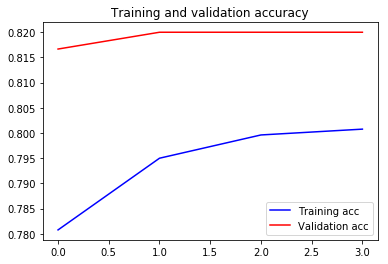

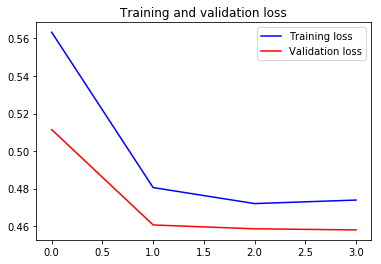

In [10]:
# Save the Model
model.save('last4_layers.h5')

# Plot the accuracy and loss curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [11]:
# Create a generator for prediction. Testing is done on images in data/test/ directory which is complete unseen data
test_generator = validation_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Get the filenames from the generator
fnames = test_generator.filenames

# Get the ground truth from generator
ground_truth = test_generator.classes

# Get the label to class mapping from the generator
label2index = test_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

Found 400 images belonging to 2 classes.


In [12]:
# Get the predictions from the model using the generator
predictions = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

40/40 [==============================] - 392s 10s/step


In [17]:
#F1 score
f1_score(ground_truth, predicted_classes, average=None)

array([0.93333333, 0.62666666])
